# Breast Cancer EDA & Modeling Notebook

## Imports & Global Config

In [1]:
# Basic libraries
import os
import sys
import logging
import importlib.util
import inspect
import subprocess
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import joblib
from xgboost import XGBClassifier

# Display + plotting style
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

# For reproducibility
RANDOM_STATE = 42


## Repository Root & Project Paths
This cell detects the project’s root folder and sets up all directory paths (data, engineered data, artifacts) so the notebook can reliably read and save files no matter where it’s run.


In [2]:
# Find the project root so all file paths work no matter where the notebook is run
def get_repo_root():
    try:
        # Ask Git for the top-level directory of this repository
        return Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip())
    except Exception:
        # Walk up a few levels looking for a .git folder
        p = Path.cwd()
        for _ in range(6):
            if (p / ".git").exists():
                return p
            p = p.parent
        # Fallback: current working directory
        return Path.cwd()

try:
    ROOT = get_repo_root()
except Exception:
    ROOT = Path.cwd()

FALLBACK_ROOT = Path(r"C:\Users\rajni\Documents\breast-cancer-agentic")
if ROOT != FALLBACK_ROOT and not (ROOT / "data" / "raw").exists():
    ROOT = FALLBACK_ROOT

print("Repo root:", ROOT)

# Define key directories
DATA_RAW        = ROOT / "data" / "raw"
DATA_ENGINEERED = ROOT / "data" / "engineered"
ARTIFACTS_ENG   = ROOT / "artifacts" / "engineering"
ARTIFACTS_EDA   = ROOT / "artifacts" / "eda"

for p in [DATA_ENGINEERED, ARTIFACTS_ENG, ARTIFACTS_EDA]:
    p.mkdir(parents=True, exist_ok=True)

# Source CSV + target column
SRC_FILE   = DATA_RAW / "breast_cancer_with_columns.csv"
TARGET_COL = "diagnosis"

print("Using source file:", SRC_FILE)
assert SRC_FILE.exists(), f"Missing source file: {SRC_FILE}"


Repo root: C:\Users\rajni\Documents\breast-cancer-agentic
Using source file: C:\Users\rajni\Documents\breast-cancer-agentic\data\raw\breast_cancer_with_columns.csv


## Load Dataset & Basic Checks
This cell loads the raw dataset, verifies that the target column exists, splits the data into features and labels, and provides basic previews (head, summary stats, missing values) to confirm the data was loaded correctly.

In [3]:
# Read the dataset from disk
df = pd.read_csv(SRC_FILE)
print("Loaded shape:", df.shape)

# Make sure the target column exists before continuing
if TARGET_COL not in df.columns:
    print("Columns available (first 40):", list(df.columns)[:40])
    raise AssertionError(f"Target column '{TARGET_COL}' not found in CSV")

# Separate features (X) from the target (y)
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

print("Target distribution (normalized):")
print(y.value_counts(normalize=True))

# Glance at the data and summary statistics to sanity-check values and types
display(df.head())
display(df.describe(include="all").T)

print("Missing values (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))


Loaded shape: (569, 32)
Target distribution (normalized):
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,569.0,NaN,NaN,NaN,30371831.432337,125020585.612224,8670.0,869218.0,906024.0,8813129.0,911320502.0
diagnosis,569,2,B,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
radius_mean,569.0,NaN,NaN,NaN,14.127292,3.524049,6.981,11.7,13.37,15.78,28.11
texture_mean,569.0,NaN,NaN,NaN,19.289649,4.301036,9.71,16.17,18.84,21.8,39.28
perimeter_mean,569.0,NaN,NaN,NaN,91.969033,24.298981,43.79,75.17,86.24,104.1,188.5
area_mean,569.0,NaN,NaN,NaN,654.889104,351.914129,143.5,420.3,551.1,782.7,2501.0
smoothness_mean,569.0,NaN,NaN,NaN,0.09636,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634
compactness_mean,569.0,NaN,NaN,NaN,0.104341,0.052813,0.01938,0.06492,0.09263,0.1304,0.3454
concavity_mean,569.0,NaN,NaN,NaN,0.088799,0.07972,0.0,0.02956,0.06154,0.1307,0.4268
concave points_mean,569.0,NaN,NaN,NaN,0.048919,0.038803,0.0,0.02031,0.0335,0.074,0.2012


Missing values (top 15):
id                        0
diagnosis                 0
radius_mean               0
texture_mean              0
perimeter_mean            0
area_mean                 0
smoothness_mean           0
compactness_mean          0
concavity_mean            0
concave points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
radius_se                 0
texture_se                0
perimeter_se              0
dtype: int64


## Data Quality Report
This cell provides a comprehensive summary of data quality: missing value rates, duplicate rows, data type distribution, and numeric ranges. These metrics help identify potential data issues before modeling and inform cleaning strategies.


In [4]:
# Missing values summary and percentage
missing_summary = pd.DataFrame({
    'column': df.columns,
    'n_missing': [df[c].isna().sum() for c in df.columns],
    'pct_missing': [100 * df[c].isna().sum() / len(df) for c in df.columns],
    'dtype': df.dtypes.values,
})
missing_summary = missing_summary[missing_summary['n_missing'] > 0].sort_values('n_missing', ascending=False)

print("=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Check for duplicates
n_duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {n_duplicates} ({100 * n_duplicates / len(df):.2f}%)")

# Missing values
if len(missing_summary) > 0:
    print(f"\nMissing Values (columns with missing data):")
    display(missing_summary[['column', 'n_missing', 'pct_missing', 'dtype']])
else:
    print(f"\n✓ No missing values detected.")

# Data type distribution
print(f"\nData Type Distribution:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  {dtype}: {count} columns")

# Numeric column ranges
print(f"\nNumeric Column Ranges (min, max, mean):")
numeric_ranges = []
for col in df.select_dtypes(include=[np.number]).columns:
    numeric_ranges.append({
        'column': col,
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'std': df[col].std(),
    })
numeric_df = pd.DataFrame(numeric_ranges)
display(numeric_df.head(10))

print(f"\n" + "=" * 80)
print("Data quality checks complete. Ready for EDA and modeling.")
print("=" * 80)


DATA QUALITY REPORT

Dataset Shape: 569 rows × 32 columns
Duplicate Rows: 0 (0.00%)

✓ No missing values detected.

Data Type Distribution:
  float64: 30 columns
  int64: 1 columns
  object: 1 columns

Numeric Column Ranges (min, max, mean):


,column,min,max,mean,std
0,id,8670.00000,9.113205e+08,3.037183e+07,1.250206e+08
1,radius_mean,6.98100,2.811000e+01,1.412729e+01,3.524049e+00
2,texture_mean,9.71000,3.928000e+01,1.928965e+01,4.301036e+00
3,perimeter_mean,43.79000,1.885000e+02,9.196903e+01,2.429898e+01
4,area_mean,143.50000,2.501000e+03,6.548891e+02,3.519141e+02
5,smoothness_mean,0.05263,1.634000e-01,9.636028e-02,1.406413e-02
6,compactness_mean,0.01938,3.454000e-01,1.043410e-01,5.281276e-02
7,concavity_mean,0.00000,4.268000e-01,8.879932e-02,7.971981e-02
8,concave points_mean,0.00000,2.012000e-01,4.891915e-02,3.880284e-02
9,symmetry_mean,0.10600,3.040000e-01,1.811619e-01,2.741428e-02



Data quality checks complete. Ready for EDA and modeling.


## Correlation Heatmap & Correlation with Target
This cell computes a correlation matrix for all numeric features and visualizes it as a heatmap, then converts the diagnosis column to a binary target (y_bin) and ranks features by how strongly they’re linearly correlated with that target.

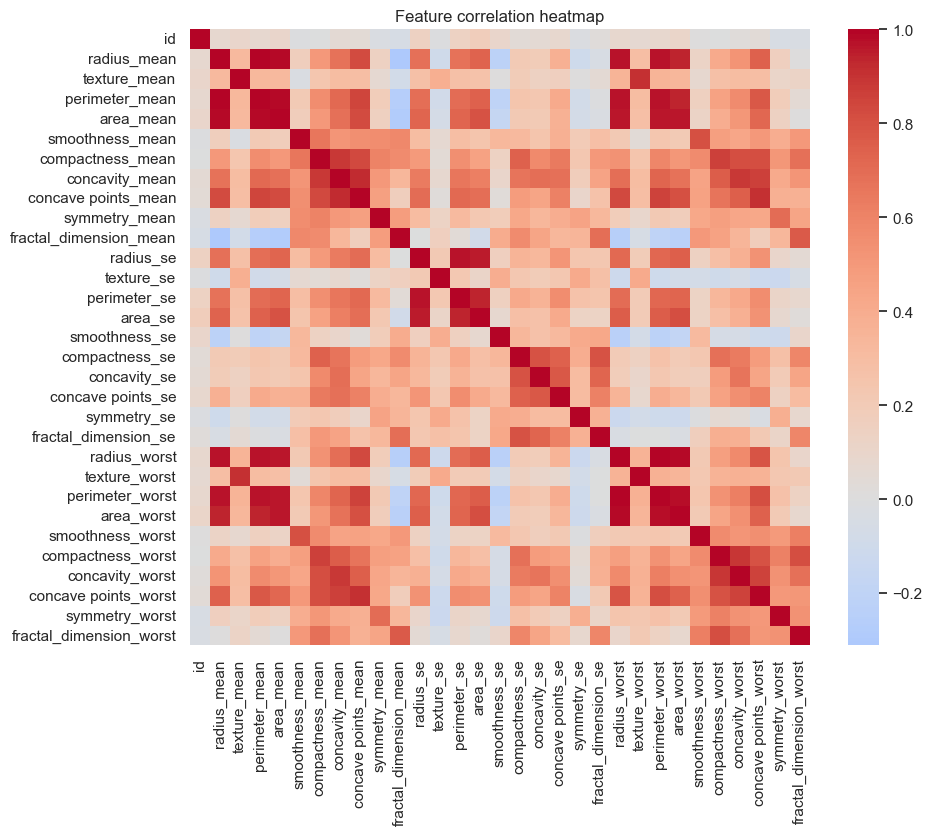

Top features by absolute correlation with target:


diagnosis               1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
compactness_mean        0.596534
compactness_worst       0.590998
radius_se               0.567134
perimeter_se            0.556141
area_se                 0.548236
texture_worst           0.456903
smoothness_worst        0.421465
symmetry_worst          0.416294
texture_mean            0.415185
Name: diagnosis, dtype: float64

In [5]:
# Correlation heatmap among numeric features
corr = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature correlation heatmap")
plt.show()

# Correlation with target: handle object target by mapping to binary
if y.dtype == 'O' or y.dtype.name == 'category':
    uniq = list(y.unique())
    if len(uniq) == 2:
        y_bin = y.map({uniq[0]: 0, uniq[1]: 1})
    else:
        # fallback: try common names
        y_bin = y.map(lambda v: 1 if str(v).lower().startswith('m') or str(v).lower().startswith('b') else 0)
else:
    y_bin = y

tmp = X.copy()
tmp[TARGET_COL] = y_bin.values
target_corr = tmp.corr()[TARGET_COL].abs().sort_values(ascending=False)
print("Top features by absolute correlation with target:")
display(target_corr.head(20))


## Statistical Significance Testing
This cell performs t-tests and chi-square tests to quantify whether observed feature differences between classes are statistically significant (beyond random chance). Results inform feature selection and help flag spurious correlations.


In [6]:
from scipy import stats

# Perform t-tests to assess feature significance vs. target
# Separate feature values by class
class_0 = y_bin.unique()[0]
class_1 = y_bin.unique()[1]

X_class_0 = X[y_bin == class_0]
X_class_1 = X[y_bin == class_1]

# Compute t-stats and p-values for each numeric feature
test_results = []
for col in X.select_dtypes(include=[np.number]).columns:
    t_stat, p_val = stats.ttest_ind(X_class_0[col].dropna(), X_class_1[col].dropna())
    test_results.append({
        'feature': col,
        't_statistic': t_stat,
        'p_value': p_val,
        'significant': 'Yes' if p_val < 0.05 else 'No',
        'mean_class_0': X_class_0[col].mean(),
        'mean_class_1': X_class_1[col].mean(),
    })

significance_df = pd.DataFrame(test_results).sort_values('p_value')
print("Features ranked by statistical significance (t-test, α=0.05):")
display(significance_df.head(15))

# Log summary
n_significant = (significance_df['p_value'] < 0.05).sum()
print(f"\nTotal numeric features: {len(X.select_dtypes(include=[np.number]).columns)}")
print(f"Statistically significant features (p < 0.05): {n_significant}")


Features ranked by statistical significance (t-test, α=0.05):


,feature,t_statistic,p_value,significant,mean_class_0,mean_class_1
28,concave points_worst,31.054555,1.969100e-124,Yes,0.182237,0.074444
23,perimeter_worst,29.965717,5.771397e-119,Yes,141.370330,87.005938
8,concave points_mean,29.354319,7.101150e-116,Yes,0.087990,0.025717
21,radius_worst,29.339082,8.482292e-116,Yes,21.134811,13.379801
3,perimeter_mean,26.405213,8.436251e-101,Yes,115.365377,78.075406
24,area_worst,25.721590,2.828848e-97,Yes,1422.286321,558.899440
1,radius_mean,25.435822,8.465941e-96,Yes,17.462830,12.146524
4,area_mean,23.938687,4.734564e-88,Yes,978.376415,462.790196
7,concavity_mean,23.103963,9.966556e-84,Yes,0.160775,0.046058
27,concavity_worst,20.897175,2.464664e-72,Yes,0.450606,0.166238



Total numeric features: 31
Statistically significant features (p < 0.05): 25


## Numeric Overview & KDE Plots
This cell reviews all numeric columns, checks missing/unique counts, and generates KDE plots to visualize how feature distributions differ between malignant and benign cases.

Numeric columns count: 31


,col,n_missing,n_unique
25,smoothness_worst,0,411
9,symmetry_mean,0,432
1,radius_mean,0,456
21,radius_worst,0,457
5,smoothness_mean,0,474
2,texture_mean,0,479
28,concave points_worst,0,492
19,symmetry_se,0,498
10,fractal_dimension_mean,0,499
29,symmetry_worst,0,500


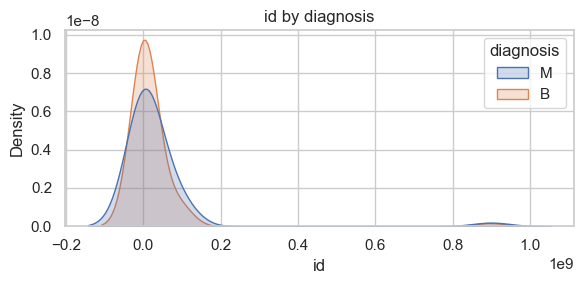

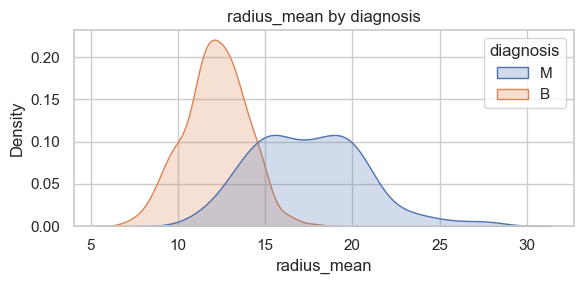

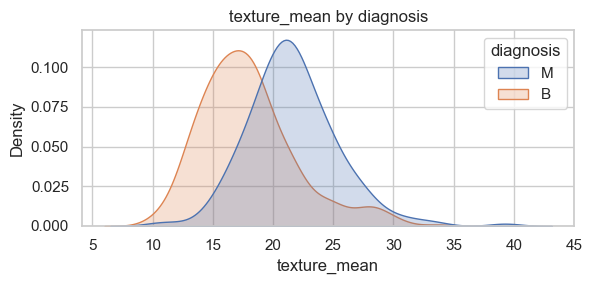

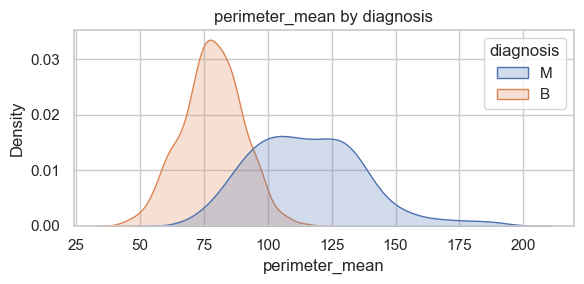

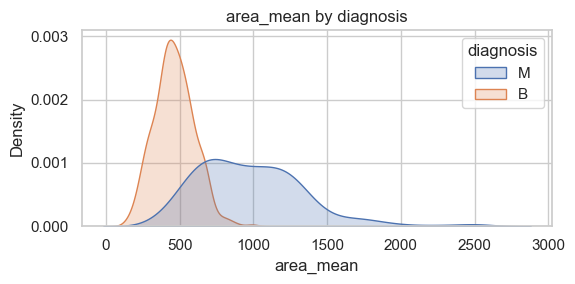

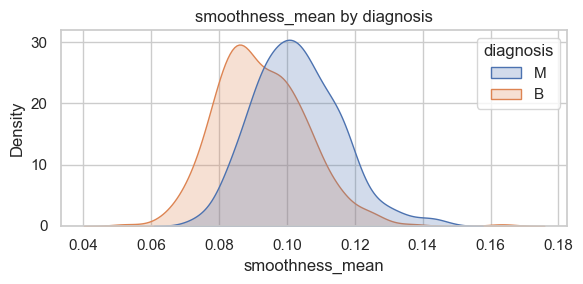

In [7]:
# Quick numeric overview and sample KDE plots
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
print("Numeric columns count:", len(num_cols))
display(pd.DataFrame({
    "col": num_cols,
    "n_missing": [X[c].isna().sum() for c in num_cols],
    "n_unique": [X[c].nunique() for c in num_cols],
}).sort_values(["n_missing", "n_unique"], ascending=[False, True]).head(20))

# Plot a few features
sel = num_cols[:6]
for col in sel:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=df, x=col, hue=TARGET_COL, fill=True, common_norm=False)
    plt.title(f"{col} by {TARGET_COL}")
    plt.tight_layout()
    plt.show()


## Outlier Detection & Visualization
This cell identifies univariate outliers using the IQR method (values beyond 1.5×IQR) and flags extreme values. This helps understand what gets clipped during percentile capping and validates the choice of clip thresholds.


Outlier Summary (IQR method):


,feature,n_outliers,pct_outliers,lower_bound,upper_bound,min_val,max_val
0,id,81,14.24,-1.104665e+07,2.072900e+07,8670.000000,9.113205e+08
14,area_se,65,11.42,-2.316000e+01,8.620000e+01,6.802000,5.422000e+02
11,radius_se,38,6.68,-1.373500e-01,8.486500e-01,0.111500,2.873000e+00
13,perimeter_se,38,6.68,-1.020500e+00,5.983500e+00,0.757000,2.198000e+01
24,area_worst,35,6.15,-3.377500e+02,1.937050e+03,185.200000,4.254000e+03
15,smoothness_se,30,5.27,7.035000e-04,1.261150e-02,0.001713,3.113000e-02
20,fractal_dimension_se,28,4.92,-1.217000e-03,8.023000e-03,0.000895,2.984000e-02
16,compactness_se,28,4.92,-1.597500e-02,6.150500e-02,0.002252,1.354000e-01
19,symmetry_se,27,4.75,2.680000e-03,3.596000e-02,0.007882,7.895000e-02
4,area_mean,25,4.39,-1.233000e+02,1.326300e+03,143.500000,2.501000e+03


C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\3468230511.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\3468230511.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\3468230511.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\3468230511.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be droppe

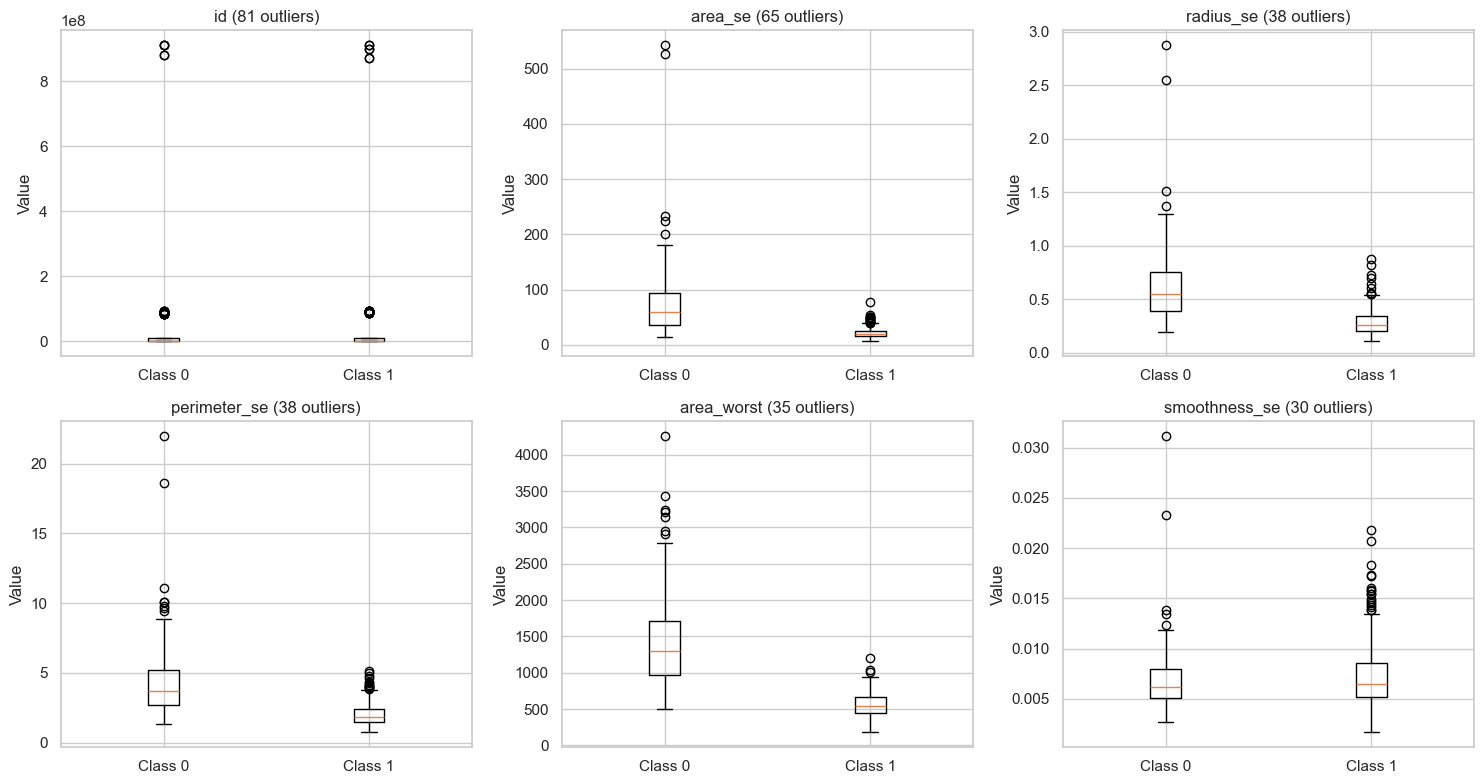


Note: 1st–99th percentile capping can be applied to reduce the impact of these outliers.


In [8]:
# OUTLIER SUMMARY USING IQR

# Create a list to store outlier information for each feature
outlier_summary = []

# Loop through all numeric columns in X
for col in X.select_dtypes(include=[np.number]).columns:
    
    # Compute the 25th and 75th percentiles
    Q1, Q3 = X[col].quantile([0.25, 0.75])
    
    # Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Identify points outside the IQR bounds
    outliers = X[(X[col] < lower) | (X[col] > upper)][col]

    # Store results for this feature
    outlier_summary.append({
        "feature": col,
        "n_outliers": len(outliers),                    # Number of outlier values
        "pct_outliers": round(100 * len(outliers) / len(X), 2),   # Outlier percentage
        "lower_bound": lower,
        "upper_bound": upper,
        "min_val": X[col].min(),
        "max_val": X[col].max(),
    })

# Create a summary DataFrame and sort by number of outliers
outlier_df = pd.DataFrame(outlier_summary).sort_values("n_outliers", ascending=False)

print("Outlier Summary (IQR method):")
display(outlier_df[outlier_df["n_outliers"] > 0].head(10))


# BOXPLOTS FOR TOP 6 FEATURES WITH THE MOST OUTLIERS

# Select the top 6 features containing the most outliers
top_cols = outlier_df[outlier_df["n_outliers"] > 0]["feature"].head(6).tolist()

if top_cols:
    
    # Set up a 2x3 grid for plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Create boxplots for each selected feature
    for idx, col in enumerate(top_cols):
        
        # Draw boxplot comparing class 0 and class 1
        axes[idx].boxplot(
            [X_class_0[col].dropna(), X_class_1[col].dropna()],
            labels=[f"Class {class_0}", f"Class {class_1}"]
        )
        
        # Get outlier count for plot title
        count = outlier_df.loc[outlier_df["feature"] == col, "n_outliers"].values[0]
        
        # Add feature name and outlier count
        axes[idx].set_title(f"{col} ({count} outliers)")
        axes[idx].set_ylabel("Value")

    # Adjust layout
    plt.tight_layout()
    
    # Display the boxplots
    plt.show()

print("\nNote: 1st–99th percentile capping can be applied to reduce the impact of these outliers.")


## Target Distribution Plot
This cell creates a simple countplot of the diagnosis column to show the class distribution (malignant vs. benign) and verify the dataset’s balance.

C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\3528557440.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=TARGET_COL, data=df,


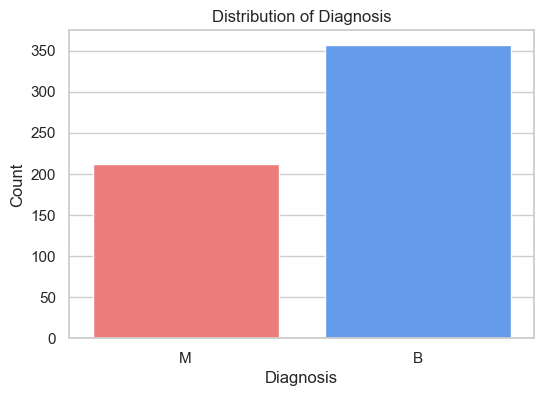

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET_COL, data=df,
    palette=["#FF6B6B", "#4D96FF"]   # red (malignant), blue (benign)
)
plt.title("Distribution of Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()


## Class Imbalance Analysis
This cell checks whether the target classes are balanced. Imbalanced datasets may require resampling strategies (oversampling, undersampling, or class weights) during modeling to prevent the model from biasing toward the majority class.


Class Distribution Summary:
  Class 0: 212 samples (37.26%)
  Class 1: 357 samples (62.74%)

Imbalance Ratio: 1.68:1

 Moderate class imbalance detected.
   • Consider class_weight='balanced'
   • SMOTE/oversampling are options
   • Use stratified CV
   • Track precision, recall, F1, ROC-AUC


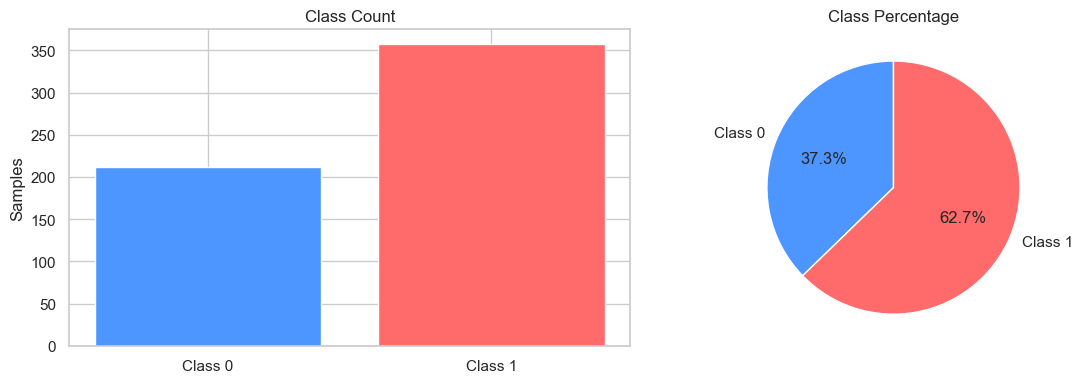

In [10]:
# Class Imbalance Check + Visuals

# Compute counts & percentages
counts = y_bin.value_counts().sort_index()
pcts = (counts / len(y_bin) * 100).round(2)
ratio = round(counts.max() / counts.min(), 2)

print("Class Distribution Summary:")
print(f"  Class 0: {counts[0]} samples ({pcts[0]}%)")
print(f"  Class 1: {counts[1]} samples ({pcts[1]}%)")
print(f"\nImbalance Ratio: {ratio}:1")

# Recommendation
if ratio > 1.5:
    print("\n Moderate class imbalance detected.")
    print("   • Consider class_weight='balanced'")
    print("   • SMOTE/oversampling are options")
    print("   • Use stratified CV")
    print("   • Track precision, recall, F1, ROC-AUC")
else:
    print("\n Classes are fairly balanced.")

# Visuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
ax1.bar(['Class 0', 'Class 1'], counts.values, color=['#4D96FF', '#FF6B6B'])
ax1.set_title("Class Count")
ax1.set_ylabel("Samples")

# Pie chart
ax2.pie(counts.values, labels=['Class 0', 'Class 1'], autopct='%1.1f%%',
        colors=['#4D96FF', '#FF6B6B'], startangle=90)
ax2.set_title("Class Percentage")

plt.tight_layout()
plt.show()


Top features (by abs corr): ['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst']


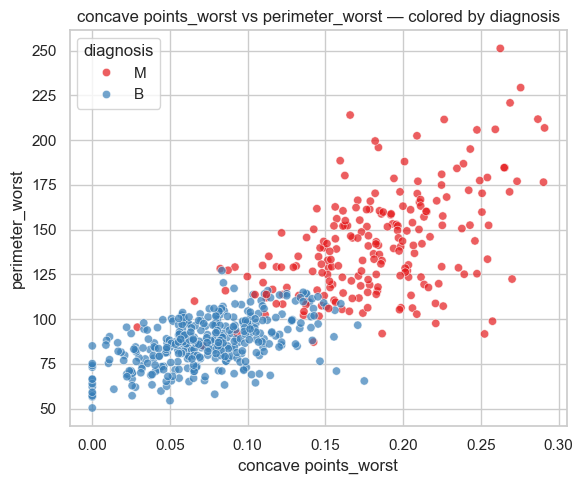

Drawing pairplot for: ['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst']


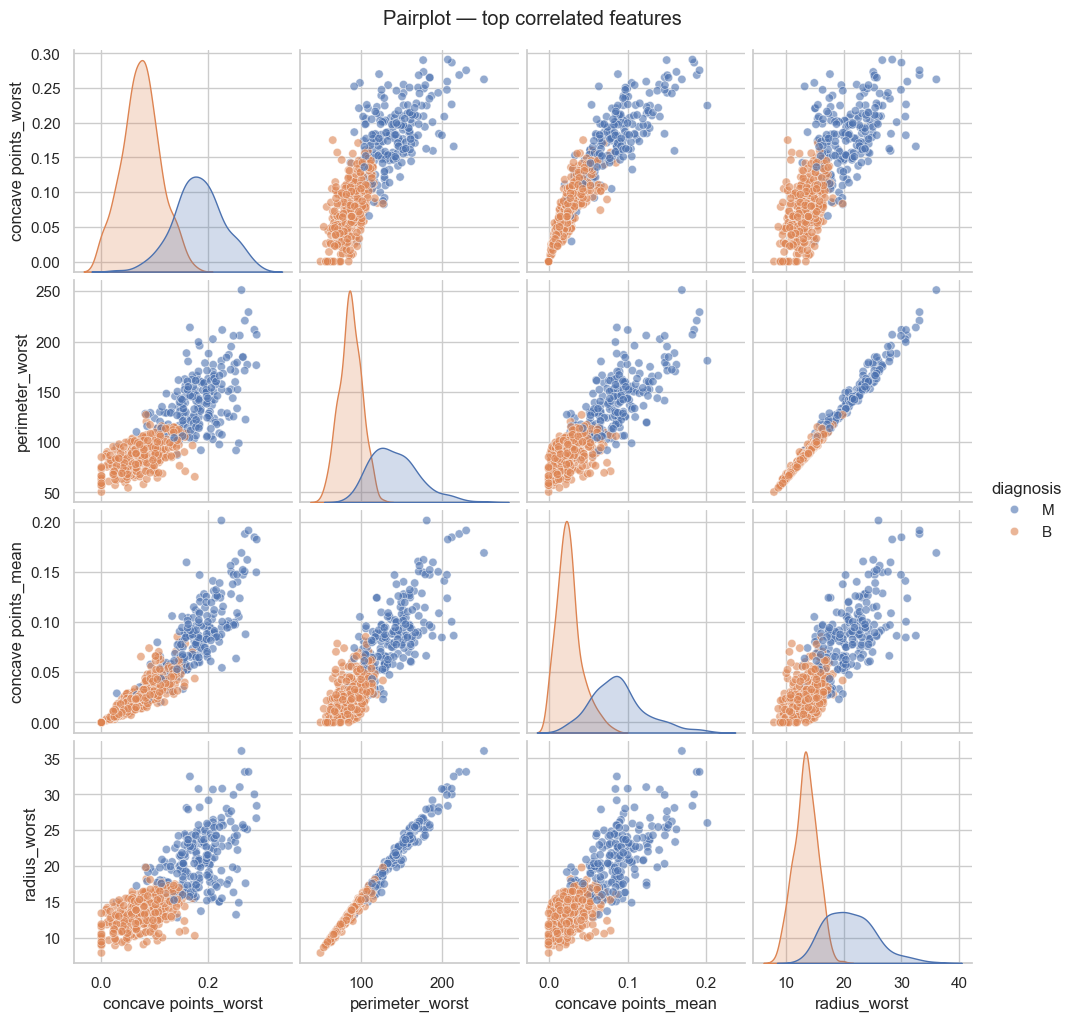

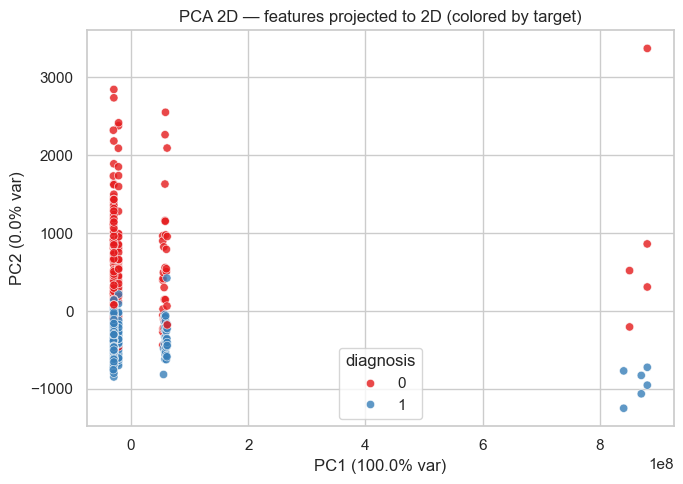

In [11]:
# Simple scatter and PCA plots (hand-written, minimal)
# 1) Scatter of two top correlated features
# 2) Small pairplot for top features
# 3) PCA 2D projection of the feature matrix

# Ensure we have a binary target variable to color plots
if 'y_bin' in globals():
    ybin = y_bin
else:
    if y.dtype == 'O':
        ybin = y.map(lambda v: 1 if str(v).lower().startswith('m') else 0)
    else:
        ybin = y

# Compute simple absolute correlations with target and pick top features
num_X = X.select_dtypes(include=[np.number])
corr_with_target = num_X.corrwith(ybin).abs().sort_values(ascending=False)
top_feats = corr_with_target.index.tolist()
print('Top features (by abs corr):', top_feats[:6])

# Scatter of two strongest features (if available)
if len(top_feats) >= 2:
    f1, f2 = top_feats[0], top_feats[1]
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x=f1, y=f2, hue=TARGET_COL, palette='Set1', alpha=0.7)
    plt.title(f'{f1} vs {f2} — colored by {TARGET_COL}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric features for a two-feature scatter.')

# Pairplot for a small subset (top 3 or 4 features)
pair_feats = top_feats[:4] if len(top_feats) >= 2 else []
if len(pair_feats) >= 2:
    print('Drawing pairplot for:', pair_feats)
    sns.pairplot(df[pair_feats + [TARGET_COL]], hue=TARGET_COL, diag_kind='kde', plot_kws={'alpha':0.6})
    plt.suptitle('Pairplot — top correlated features', y=1.02)
    plt.show()

# PCA 2D projection (use scaled features if available)
from sklearn.decomposition import PCA
X_pca_in = X_scaled if 'X_scaled' in globals() else num_X.fillna(0)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X2 = pca.fit_transform(X_pca_in)
explained = pca.explained_variance_ratio_
plt.figure(figsize=(7,5))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=ybin, palette='Set1', alpha=0.8)
plt.xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
plt.title('PCA 2D — features projected to 2D (colored by target)')
plt.tight_layout()
plt.show()

## Agent Loader & Safe Adapter
This cell makes sure our notebook can load and run the AI agents stored in the agents/ folder — no matter who runs the notebook or how their environment is set up.
This cell handles these possible situations:
1. Try normal package import
2. If that fails, try loading agent modules directly from file paths
3. If both imports fail, we use "safe stub versions"
4. Safe-call adapter - No matter how the agent is written, the notebook can still call it without errors.
5. Finally, it executes the agent

In [12]:
# If not set, adapter will only use in-memory df. DATA_PATH can be set to a CSV path
# so agents that expect file-based input can be invoked without writing temp files.
DATA_PATH = globals().get("DATA_PATH", None)

# Resolve project root so notebook works when executed from subfolders
# If the notebook runs inside a `notebooks/` folder we assume the repo root is its parent.
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Directory where agent modules are expected to live (project-local adapters/agents)
AGENTS_DIR = ROOT / "agents"

# Ensure artifact directory exists and configure structured logging (file + console)
os.makedirs(str(ARTIFACTS_EDA), exist_ok=True)
log_file = ARTIFACTS_EDA / f"agent_adapter_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.log"
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s: %(message)s',
                    filename=str(log_file))
console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(asctime)s %(levelname)s: %(message)s'))
logging.getLogger().addHandler(console)

logging.info("ROOT: %s", ROOT)
logging.info("AGENTS_DIR: %s | exists: %s", AGENTS_DIR, AGENTS_DIR.exists())
logging.info("__init__.py present: %s", (AGENTS_DIR / "__init__.py").exists())

# Audit logger (writes newline-delimited JSON records to artifacts)
try:
    from agents.audit_logger import get_default_audit
    audit = get_default_audit(artifacts_dir=ARTIFACTS_EDA)
    logging.info("Audit logger initialized at: %s", audit.filepath)
except Exception as e_audit:
    logging.info("Audit logger not available: %s", e_audit)
    audit = None

# Privacy utilities (de-identification)
try:
    from agents.privacy import deidentify_to_temp_csv, deidentify_dataframe
    logging.info("Privacy utilities available (deidentify_to_temp_csv)")
except Exception as e_priv:
    logging.info("Privacy utilities not available: %s", e_priv)
    deidentify_to_temp_csv = None
    deidentify_dataframe = None

# Track whether we found real agent implementations
AGENTS_AVAILABLE = False

# Helper: import a module directly from a file path (keeps our flexible loading strategy)
# This allows the notebook to load `agents/eda_agent.py` without requiring package install.
def load_module_by_path(mod_name, path: Path):
    spec = importlib.util.spec_from_file_location(mod_name, str(path))
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

# Import strategy (resilient):
# 1) Try normal package import (preferred for packaged deployments)
# 2) If that fails, try loading agent modules by explicit file path (developer convenience)
# 3) If both fail, provide safe no-op stubs so the notebook remains runnable.
try:
    from agents.eda_agent import run_eda_report  # expected callable
    from agents.fe_agent import propose_features, apply_features
    AGENTS_AVAILABLE = True
    logging.info("Imported agents via package imports.")
except Exception as e_pkg:
    logging.info("Package import failed: %s", e_pkg)
    try:
        # Try loading agent files directly from `agents/`
        eda_path = AGENTS_DIR / "eda_agent.py"
        fe_path = AGENTS_DIR / "fe_agent.py"

        eda_mod = load_module_by_path("agents.eda_agent", eda_path)
        run_eda_report = getattr(eda_mod, "run_eda_report", None)

        fe_mod = load_module_by_path("agents.fe_agent", fe_path) if fe_path.exists() else None
        propose_features = getattr(fe_mod, "propose_features", None) if fe_mod else None
        apply_features = getattr(fe_mod, "apply_features", None) if fe_mod else None

        if callable(run_eda_report):
            AGENTS_AVAILABLE = True
            logging.info("Loaded agents via file path.")
        else:
            raise ImportError("run_eda_report not found in eda_agent.py")
    except Exception as e_path:
        logging.info("File-path import failed: %s", e_path)

        # Safe no-op stubs: allow notebook to proceed even without real agents
        def run_eda_report(df, target_col=None, out_dir="artifacts/eda"):
            # Stub: indicates no EDA was performed on purpose
            logging.info("run_eda_report stub called — no real EDA performed.")
            return {"summary_path": None, "out_dir": out_dir}

        def propose_features(X, y=None, max_interactions=20):
            logging.info("propose_features stub called.")
            return []

        def apply_features(X, proposals, dry_run=True, confirm=False):
            """Apply feature proposals to `X` (stubbed).

            Behavior:
            - `dry_run=True` (default): do not persist changes; return transformed DataFrame + metadata.
            - `dry_run=False`: requires explicit confirmation. Confirmation sources (in order):
                1) `confirm=True` argument
                2) `globals().get('CONFIRM_APPLY', False)` set in the notebook
                3) interactive user input (type 'yes')

            This pattern prevents accidental destructive edits when running notebooks non-interactively.
            """
            logging.info("apply_features called (dry_run=%s, confirm=%s)", dry_run, confirm)
            X_new = X.copy()
            applied = []

            # Emit an audit event for the apply attempt (if audit logger is present)
            if 'audit' in globals() and audit is not None:
                try:
                    ctx = audit.audit_event(event_type='apply_features', actor='notebook', action='apply',
                                            target=str(ARTIFACTS_ENG / 'transformers.pkl'),
                                            details={'dry_run': dry_run, 'n_proposals': len(proposals) if proposals else 0})
                except Exception:
                    ctx = None
            else:
                ctx = None

            if ctx:
                cm = ctx.__enter__()

            # In a real implementation we'd apply transformations described by `proposals`.
            # Here the stub simply records proposal names to demonstrate metadata structure.
            for p in proposals or []:
                name = p.get("name") if isinstance(p, dict) else str(p)
                applied.append(name)

            metadata = {"applied": applied, "count": len(applied)}

            if dry_run:
                logging.info("Dry-run mode: no changes persisted. Metadata: %s", metadata)
                if ctx:
                    ctx.__exit__(None, None, None)
                return X_new, metadata

            # Non-dry run path: require confirmation
            global_confirm = globals().get("CONFIRM_APPLY", False)
            if not confirm and not global_confirm:
                # Try to prompt interactively; this will raise in headless CI if input() is unavailable
                try:
                    ans = input("Apply feature proposals to dataset? Type 'yes' to proceed: ").strip().lower()
                    if ans != "yes":
                        logging.info("User declined to apply features via prompt.")
                        raise RuntimeError("User declined to apply features (no changes made).")
                except Exception:
                    raise RuntimeError("Confirmation required to apply features; set CONFIRM_APPLY=True or pass confirm=True.")

            # At this point we consider changes "approved". Stub does not persist to disk.
            logging.info("Applying features (stub) — metadata: %s", metadata)
            if ctx:
                ctx.__exit__(None, None, None)
            return X_new, metadata

        logging.info("Using stubbed agent functions (no-op).")

# Compatibility adapter: call run_eda_report regardless of its exact signature
# The adapter supports functions that accept either a DataFrame (`df`) or a file path
# argument (`dataset_path` or `path`), and it also tries common positional forms.
def call_run_eda_safely(run_eda_report_fn, df, target_col, out_dir, data_path=None, **extra):
    """Call run_eda_report whether it expects a DataFrame or a file path.
    The adapter inspects the function signature and tries the most likely calling conventions.
    """
    if run_eda_report_fn is None or not callable(run_eda_report_fn):
        raise RuntimeError("run_eda_report is not callable; agent import failed.")

    params = inspect.signature(run_eda_report_fn).parameters
    kw = dict(target_col=target_col, out_dir=str(out_dir), **extra)

    # Case 1: function expects an explicit DataFrame named `df`
    if "df" in params:
        return run_eda_report_fn(df=df, **kw)

    # Case 2: function expects a dataset path argument (common in detached agents)
    if "dataset_path" in params or "path" in params:
        if data_path is None:
            raise ValueError("Agent expects a file path — set DATA_PATH before calling.")
        key = "dataset_path" if "dataset_path" in params else "path"
        kw[key] = data_path
        return run_eda_report_fn(**kw)

    # Case 3: positional arguments fallback (df, target_col, out_dir) or (path, target_col, out_dir)
    try:
        return run_eda_report_fn(df, target_col, str(out_dir), **extra)
    except TypeError:
        if data_path is None:
            raise
        return run_eda_report_fn(data_path, target_col, str(out_dir), **extra)

# --- Safety improvement: run agents in a subprocess with timeout when possible ---
# We prefer subprocess runs because they are interruptible via the OS, easier to sandbox,
# and their stdout/stderr can be captured independently of the notebook process.
import json, tempfile, textwrap

# Write a DataFrame to a temp CSV and return the path. Caller should remove the file.
def _df_to_temp_csv(df):
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".csv")
    df.to_csv(tmp.name, index=False)
    tmp.close()
    return tmp.name

# Create a small runner script that imports the agent and calls it using a dataset_path.
# The runner prints a JSON object to stdout so the parent process can parse structured results.
def _write_runner_script(use_file_path=None):
    if use_file_path:
        # Load the agent directly from the source file to avoid altering sys.path in the
        # runner process (safer and more deterministic).
        import_block = f"import importlib.util\nspec = importlib.util.spec_from_file_location('agent_mod', r'{use_file_path}')\nmod = importlib.util.module_from_spec(spec)\nspec.loader.exec_module(mod)\nfrom agent_mod import run_eda_report"
    else:
        # Default to importing the package name `agents.eda_agent` in environments
        # where the project is installed/packaged.
        import_block = "from agents.eda_agent import run_eda_report"

    script = textwrap.dedent(f"""
import json, sys, traceback
try:
    {import_block}
    dataset = sys.argv[1]
    target = sys.argv[2]
    outdir = sys.argv[3]
    res = run_eda_report(dataset_path=dataset, target_col=target, out_dir=outdir)
    print(json.dumps({'success': True, 'result': res}, default=str))
except Exception as e:
    print(json.dumps({'success': False, 'error': str(e), 'traceback': traceback.format_exc()}))
""")
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".py", mode="w", encoding="utf-8")
    tmp.write(script)
    tmp.close()
    return tmp.name

# Run the tiny runner script in a subprocess, capture stdout/stderr, save them to ARTIFACTS_EDA,
# and return the parsed result object (or raise on errors).
def run_eda_via_subprocess(eda_py_path_or_none, dataset_path, target_col, out_dir, timeout=30):
    runner = _write_runner_script(use_file_path=eda_py_path_or_none)
    try:
        cmd = [sys.executable, runner, dataset_path, str(target_col), str(out_dir)]
        cp = subprocess.run(cmd, capture_output=True, text=True, timeout=timeout)
        stdout = cp.stdout.strip()
        stderr = cp.stderr or ''

        # Persist stdout/stderr to artifact logs for later debugging (timestamped)
        ts = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
        try:
            out_path = ARTIFACTS_EDA / f'agent_stdout_{ts}.log'
            err_path = ARTIFACTS_EDA / f'agent_stderr_{ts}.log'
            out_path.write_text(cp.stdout)
            err_path.write_text(cp.stderr or '')
            logging.info("Saved agent stdout to %s and stderr to %s", out_path, err_path)
            # Record audit info about the subprocess result
            try:
                if 'audit' in globals() and audit is not None:
                    audit.log('agent_subprocess', actor='agent_runner', action='subprocess_complete',
                              target=str(dataset_path),
                              details={'stdout_log': str(out_path), 'stderr_log': str(err_path), 'runner': str(runner)})
            except Exception:
                logging.exception("Failed to emit audit record for agent subprocess")
        except Exception as e_write:
            logging.exception("Failed to write agent stdout/stderr to artifacts: %s", e_write)

        # Expect the runner to print a JSON object. If not, raise with output included.
        try:
            obj = json.loads(stdout)
        except Exception:
            logging.error("Agent runner did not return valid JSON. stdout=%r stderr=%r", stdout, stderr)
            raise RuntimeError(f"Agent runner failed to return JSON. stdout={stdout!r}, stderr={cp.stderr!r}")

        if not obj.get('success'):
            logging.error("Agent reported failure: %s", obj.get('error',''))
            raise RuntimeError('Agent error: ' + obj.get('error','') + '\n' + obj.get('traceback',''))

        logging.info("Agent subprocess completed successfully")
        return obj.get('result')
    finally:
        # Try to clean up the temporary runner script file.
        try:
            Path(runner).unlink()
        except Exception:
            pass

# High-level wrapper that prefers subprocess execution paths and falls back to in-process calls.
def run_eda_with_timeout(run_eda_report_fn, df, target_col, out_dir, data_path=None, timeout=30):
    """High-level wrapper: prefer subprocess runs (file or package), otherwise in-process fallback.

    Steps:
    1. If `agents/eda_agent.py` exists locally, run it in a subprocess using that file.
    2. Else try importing `agents.eda_agent` in a subprocess (works when project is installed).
    3. If subprocess paths fail, fall back to calling the function in-process with a thread-based timeout.
       Note: thread-based timeouts cannot terminate CPU-bound C extensions; subprocess is preferred.
    """
    # 1) If there's a local eda_agent.py, prefer running it in a subprocess (safer)
    eda_file = AGENTS_DIR / "eda_agent.py"
    if eda_file.exists():
        # prepare dataset path: de-identify if possible
        if data_path:
            ds = data_path
        else:
            deid_strategy = globals().get('DEID_STRATEGY', 'drop')
            deid_cols = globals().get('DEID_COLS', None)
            deid_salt = globals().get('DEID_SALT', 'agentic-default-salt')
            if deidentify_to_temp_csv:
                ds = deidentify_to_temp_csv(df, strategy=deid_strategy, cols=deid_cols, salt=deid_salt)
                try:
                    if audit:
                        audit.log('deidentify', actor='notebook', action='deidentify_to_temp_csv', target=str(ds), details={'strategy': deid_strategy, 'cols': deid_cols})
                except Exception:
                    logging.exception("Failed to emit audit record for de-identification")
            else:
                ds = _df_to_temp_csv(df)
        try:
            return run_eda_via_subprocess(str(eda_file), ds, target_col, out_dir, timeout=timeout)
        finally:
            if data_path is None:
                try: Path(ds).unlink()
                except: pass

    # 2) Try package import path via subprocess
    try:
        __import__("agents.eda_agent")
        if data_path:
            ds = data_path
        else:
            deid_strategy = globals().get('DEID_STRATEGY', 'drop')
            deid_cols = globals().get('DEID_COLS', None)
            deid_salt = globals().get('DEID_SALT', 'agentic-default-salt')
            if deidentify_to_temp_csv:
                ds = deidentify_to_temp_csv(df, strategy=deid_strategy, cols=deid_cols, salt=deid_salt)
                try:
                    if audit:
                        audit.log('deidentify', actor='notebook', action='deidentify_to_temp_csv', target=str(ds), details={'strategy': deid_strategy, 'cols': deid_cols})
                except Exception:
                    logging.exception("Failed to emit audit record for de-identification")
            else:
                ds = _df_to_temp_csv(df)
        try:
            return run_eda_via_subprocess(None, ds, target_col, out_dir, timeout=timeout)
        finally:
            if data_path is None:
                try: Path(ds).unlink()
                except: pass
    except Exception as e_pkg2:
        logging.info("Package-based subprocess run not available: %s", e_pkg2)

    # 3) Last resort: call in-process with a thread timeout (cannot kill CPU-bound tasks)
    from concurrent.futures import ThreadPoolExecutor, TimeoutError
    with ThreadPoolExecutor(max_workers=1) as ex:
        fut = ex.submit(call_run_eda_safely, run_eda_report_fn, df, target_col, out_dir, data_path=data_path)
        try:
            return fut.result(timeout=timeout)
        except TimeoutError:
            raise TimeoutError(f"Agent call timed out after {timeout} seconds (in-process fallback)")

# Execute via safe adapter (works for real agent or stub), with a sensible default timeout
try:
    logging.info("Calling run_eda_report via safe adapter (timeout=%ss)", 30)
    if "df" not in globals():
        raise NameError("df is not defined in this notebook cell scope.")
    if audit:
        with audit.audit_event(event_type='eda_run', actor='notebook', action='run_eda', target=str(SRC_FILE), details={'timeout': 30}):
            result = run_eda_with_timeout(
                run_eda_report_fn=run_eda_report,
                df=df,
                target_col=TARGET_COL,
                out_dir=ARTIFACTS_EDA,
                data_path=DATA_PATH,
                timeout=30,  # seconds; adjust as needed
            )
    else:
        result = run_eda_with_timeout(
            run_eda_report_fn=run_eda_report,
            df=df,
            target_col=TARGET_COL,
            out_dir=ARTIFACTS_EDA,
            data_path=DATA_PATH,
            timeout=30,  # seconds; adjust as needed
        )
    logging.info("run_eda_report executed; artifacts (if any) saved to: %s", ARTIFACTS_EDA)
    if result is not None:
        try:
            logging.info("Agent result keys: %s", list(result.keys()))
        except Exception:
            logging.info("Agent result type: %s", type(result))
except Exception:
    logging.exception("run_eda_report execution failed")

C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\2247642032.py:16: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  log_file = ARTIFACTS_EDA / f"agent_adapter_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.log"
2025-11-16 14:02:39,075 INFO: ROOT: C:\Users\rajni\Documents\breast-cancer-agentic
2025-11-16 14:02:39,076 INFO: AGENTS_DIR: C:\Users\rajni\Documents\breast-cancer-agentic\agents | exists: True
2025-11-16 14:02:39,078 INFO: __init__.py present: True
2025-11-16 14:02:39,090 INFO: Audit logger initialized at: C:\Users\rajni\Documents\breast-cancer-agentic\artifacts\eda\audit_log.jsonl
2025-11-16 14:02:39,094 INFO: Privacy utilities available (deidentify_to_temp_csv)
2025-11-16 14:02:39,097 INFO: Imported agents via package imports.
2025-11-16 14:02:39,103 INFO: Calling run_eda_report via safe adapter (timeout=30s)
2025-11-16 1

## Baseline Feature Engineering
This cell applies our baseline feature engineering: it creates ratio features (worst / mean) for key measurements and removes all _se standard-error columns to reduce noise and dimensionality.

In [13]:
# Create ratio features and drop *_se columns
def add_ratio_features(df):
    df = df.copy()
    pairs = [
        ('radius_mean','radius_worst'),
        ('texture_mean','texture_worst'),
        ('perimeter_mean','perimeter_worst'),
        ('area_mean','area_worst'),
        ('smoothness_mean','smoothness_worst'),
        ('compactness_mean','compactness_worst'),
        ('concavity_mean','concavity_worst'),
        ('concave points_mean','concave points_worst'),
        ('symmetry_mean','symmetry_worst'),
        ('fractal_dimension_mean','fractal_dimension_worst'),
    ]
    for a, b in pairs:
        if a in df.columns and b in df.columns:
            with np.errstate(divide='ignore', invalid='ignore'):
                df[f'{b}_over_{a}'] = df[b] / df[a]
    return df

def drop_se_columns(df):
    return df.drop(columns=[c for c in df.columns if str(c).endswith('_se')], errors='ignore')

X_fe = add_ratio_features(X)
X_fe = drop_se_columns(X_fe)
print("Feature-engineered shape:", X_fe.shape)


Feature-engineered shape: (569, 31)


## Cap Percentiles, Scale, Save Engineered Data & Transformers
This cell caps outliers using percentile clipping, scales all features with StandardScaler, and then saves the engineered dataset and transformer metadata for consistent reuse across the project.

In [14]:
def cap_percentiles(df, lower=0.01, upper=0.99):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        lo = df[col].quantile(lower)
        hi = df[col].quantile(upper)
        df[col] = df[col].clip(lo, hi)
    return df

lower_pct, upper_pct = 0.01, 0.99
X_cap = cap_percentiles(X_fe, lower=lower_pct, upper=upper_pct)

# Record clip bounds for metadata
clip_lower = {}
clip_upper = {}
for col in X_fe.select_dtypes(include=[np.number]).columns:
    clip_lower[col] = float(X_fe[col].quantile(lower_pct))
    clip_upper[col] = float(X_fe[col].quantile(upper_pct))

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_cap), columns=X_cap.columns)

fe_metadata = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "clip_percentiles": {"lower": lower_pct, "upper": upper_pct},
    "clip_bounds": {"lower": clip_lower, "upper": clip_upper},
    "feature_columns": list(X_scaled.columns),
    "transform": "cap_percentiles + StandardScaler",
}

out_df = X_scaled.copy()
out_df[TARGET_COL] = y.values

ENGINEERED_PATH = DATA_ENGINEERED / "breast_cancer_engineered.csv"
out_df.to_csv(ENGINEERED_PATH, index=False)

joblib.dump({'scaler': scaler, 'columns': list(X_scaled.columns), 'fe_metadata': fe_metadata},
            ARTIFACTS_ENG / 'transformers.pkl')

print("Saved engineered data to:", ENGINEERED_PATH)
print("Saved transformers to:", ARTIFACTS_ENG / "transformers.pkl")


C:\Users\rajni\AppData\Local\Temp\ipykernel_20440\4106625825.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


Saved engineered data to: C:\Users\rajni\Documents\breast-cancer-agentic\data\engineered\breast_cancer_engineered.csv
Saved transformers to: C:\Users\rajni\Documents\breast-cancer-agentic\artifacts\engineering\transformers.pkl


## Mutual Information Ranking
This cell computes Mutual Information scores to measure how strongly each feature relates to the target, and saves a ranked list of the most informative features for later modeling.

In [15]:
# Impute missing values with column mean
imp = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imp.fit_transform(X_scaled),
                         columns=X_scaled.columns, index=X_scaled.index)

# Select correct target (y_bin if present else y)
target = y_bin if 'y_bin' in globals() else y

# Compute mutual information
mi = mutual_info_classif(X_imputed, target, random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_imputed.columns).sort_values(ascending=False)

# Save ranking
mi_csv_path = ARTIFACTS_EDA / "mutual_info_ranking.csv"
mi_series.to_csv(mi_csv_path)
print("Saved mutual info ranking to:", mi_csv_path)

mi_series.head(10)


Saved mutual info ranking to: C:\Users\rajni\Documents\breast-cancer-agentic\artifacts\eda\mutual_info_ranking.csv


perimeter_worst                  0.475499
area_worst                       0.462673
radius_worst                     0.453255
concave points_mean              0.439841
concave points_worst             0.434507
perimeter_mean                   0.404176
concavity_mean                   0.372995
radius_mean                      0.366520
area_mean                        0.359182
radius_worst_over_radius_mean    0.319619
dtype: float64

## Train/Test Split
This cell splits the processed data into training and testing sets (using stratification) so we can train models fairly and evaluate them on unseen data.

In [16]:
# Use the same target as MI (binary if available)
target = y_bin if 'y_bin' in globals() else y

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=target,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (455, 31)
Test shape: (114, 31)


## XGBoost + GridSearchCV Modeling
This cell trains an XGBoost model using GridSearchCV to find the best hyperparameters, then evaluates the final model on the test set using ROC-AUC, classification metrics, and a confusion matrix.

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


C:\Users\rajni\Documents\breast-cancer-agentic\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:04:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters Found: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 400, 'reg_lambda': 1, 'subsample': 0.8}
Best ROC-AUC Score from CV: 0.9933781822978499
Test ROC-AUC: 0.9993386243386243

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



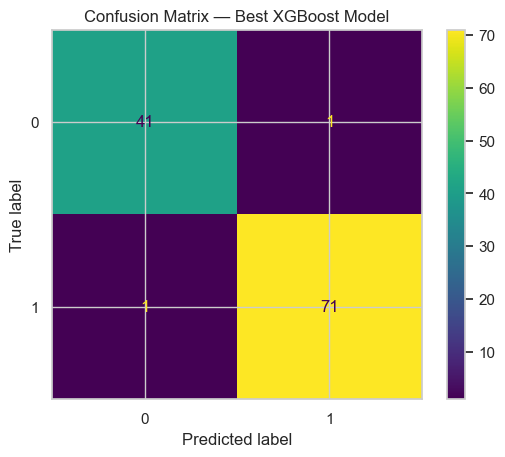

In [17]:
# Define base XGBoost model
xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    tree_method="hist",
    eval_metric="logloss",
    use_label_encoder=False,
)

# Hyperparameter grid (your earlier setup)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [400],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],
    'min_child_weight': [1, 3, 5],
}

# Stratified K-fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Best Parameters Found:", grid.best_params_)
print("Best ROC-AUC Score from CV:", grid.best_score_)

# Evaluate on test set
y_proba = grid.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC:", test_auc)

y_pred = grid.predict(X_test)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)
plt.title("Confusion Matrix — Best XGBoost Model")
plt.show()


***EDA & Feature Engineering Handoff Summary***

This section summarizes all artifacts and insights prepared for the modeling team.

**Data Prepared**

**Engineered Dataset**: data/engineered/breast_cancer_engineered.csv

    All features scaled using StandardScaler

    Outliers capped at the 1st and 99th percentiles

    Ratio features created (worst / mean for key measurements)

    Standard error columns removed

    Shape: same number of rows as original dataset; engineered feature count shown in columns

Transformer Artifacts: artifacts/engineering/transformers.pkl

    Contains the StandardScaler, feature column names, and clip-bounds metadata

    Use this file to transform test or production data consistently

**Key Findings from EDA**

    Statistical tests identified features with p < 0.05 (see Statistical Significance Testing section)

    IQR-based outlier detection was performed and boxplots generated

    Class imbalance ratio was calculated; recommendations provided if the ratio was greater than 1.5

    Mutual Information feature ranking saved to artifacts/eda/mutual_info_ranking.csv

**Quality Checks**

    Data types validated; all modeling features confirmed as numeric

    Missing value rates documented in the Data Quality Report

    Duplicate rows checked and reported

    Numeric ranges (min, max, mean, standard deviation) computed for all numeric features

**Safety and Auditability**

    Audit log stored in artifacts/eda/audit_log.jsonl for full traceability

    Raw data was already de-identified before processing

    All clip bounds and transformations recorded in transformers.pkl

**Recommendations for the Modeling Team**

    Use MI ranking and t-test results when selecting features

    If class imbalance ratio is greater than 1.5, use class_weight='balanced'

    Continue using stratified K-fold (3 splits) for reproducibility

    Evaluate models using ROC-AUC, precision, recall, and F1 rather than accuracy alone

    Apply the saved scaler from transformers.pkl to test or new data before prediction

**Output Files Checklist**

    data/engineered/breast_cancer_engineered.csv — engineered dataset

    artifacts/engineering/transformers.pkl — scaler and metadata

    artifacts/eda/mutual_info_ranking.csv — feature importance ranking

    artifacts/eda/audit_log.jsonl — traceability log

    artifacts/eda/agent_adapter_*.log — execution logs

EDA and feature engineering are complete. The data is clean, validated, and ready for modeling.